In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import joblib

# Configurações para visualização dos gráficos
plt.style.use('ggplot')
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)


In [178]:
def load_and_prepare_data():
    """
    Função para carregar e preparar os dados para modelagem a partir do banco de dados SQLite.
    """
    # Criando a conexão com o banco de dados
    db_path = r'C:\Users\louis\datatech\Database\walmart_fraudes.db'
    conn = sqlite3.connect(db_path)

    # Lendo as tabelas diretamente do banco de dados
    orders_df = pd.read_sql("SELECT * FROM orders", conn)
    drivers_df = pd.read_sql("SELECT * FROM drivers", conn)
    customers_df = pd.read_sql("SELECT * FROM customers", conn)
    missing_items_df = pd.read_sql("SELECT * FROM missing_items", conn)
    products_df = pd.read_sql("SELECT * FROM products", conn)

    # Pré-processamento dos dados
    orders_df['order_amount'] = orders_df['order_amount'].astype(float)
    orders_df['date'] = pd.to_datetime(orders_df['date'])
    orders_df['delivery_hour_only'] = orders_df['delivery_hour'].apply(lambda x: int(x.split(':')[0]))
    orders_df['delivery_minute'] = orders_df['delivery_hour'].apply(lambda x: int(x.split(':')[1]))
    orders_df['delivery_second'] = orders_df['delivery_hour'].apply(lambda x: int(x.split(':')[2]))

    def categorize_time(hour):
        if 5 <= hour < 12:
            return 'Manhã'
        elif 12 <= hour < 18:
            return 'Tarde'
        else:
            return 'Noite'

    orders_df['period_of_day'] = orders_df['delivery_hour_only'].apply(categorize_time)

    # Criando features agregadas para motoristas
    driver_features_query = """
    SELECT 
        d.driver_id,
        d.age,
        d.Trips,
        COUNT(o.order_id) AS orders_delivered,
        AVG(o.items_missing) AS avg_missing_items,
        SUM(o.items_missing) AS total_missing_items,
        SUM(o.items_delivered) AS total_delivered_items,
        SUM(o.items_delivered + o.items_missing) AS total_items,
        CAST(SUM(o.items_missing) AS FLOAT) / 
            CAST(SUM(o.items_delivered + o.items_missing) AS FLOAT) AS missing_ratio,
        AVG(o.order_amount) AS avg_order_amount,
        SUM(CASE WHEN o.items_missing > 0 THEN 1 ELSE 0 END) AS orders_with_missing,
        CAST(SUM(CASE WHEN o.items_missing > 0 THEN 1 ELSE 0 END) AS FLOAT) / 
            CAST(COUNT(o.order_id) AS FLOAT) AS problem_order_ratio
    FROM 
        drivers d
    JOIN 
        orders o ON d.driver_id = o.driver_id
    GROUP BY 
        d.driver_id
    """
    driver_features = pd.read_sql(driver_features_query, conn)

    # Limpar espaços extras nos nomes das colunas
    driver_features.columns = driver_features.columns.str.strip()

    # Verificar se a coluna 'missing_ratio' existe em driver_features
    if 'missing_ratio' in driver_features.columns:
        print("A coluna 'missing_ratio' existe em driver_features!")
    else:
        print("A coluna 'missing_ratio' NÃO existe em driver_features!")

    # Criando features agregadas para clientes
    customer_features_query = """
    SELECT 
        c.customer_id,
        c.customer_age,
        COUNT(o.order_id) AS orders_placed,
        AVG(o.items_missing) AS avg_missing_items,
        SUM(o.items_missing) AS total_missing_items,
        SUM(o.items_delivered) AS total_delivered_items,
        SUM(o.items_delivered + o.items_missing) AS total_items,
        CAST(SUM(o.items_missing) AS FLOAT) / 
            CAST(SUM(o.items_delivered + o.items_missing) AS FLOAT) AS missing_ratio,
        AVG(o.order_amount) AS avg_order_amount,
        SUM(CASE WHEN o.items_missing > 0 THEN 1 ELSE 0 END) AS orders_with_missing,
        CAST(SUM(CASE WHEN o.items_missing > 0 THEN 1 ELSE 0 END) AS FLOAT) / 
            CAST(COUNT(o.order_id) AS FLOAT) AS problem_order_ratio
    FROM 
        customers c
    JOIN 
        orders o ON c.customer_id = o.customer_id
    GROUP BY 
        c.customer_id
    """
    customer_features = pd.read_sql(customer_features_query, conn)

    # Limpar espaços extras nos nomes das colunas
    customer_features.columns = customer_features.columns.str.strip()

    # Verificar se a coluna 'missing_ratio' existe em customer_features
    if 'missing_ratio' in customer_features.columns:
        print("A coluna 'missing_ratio' existe em customer_features!")
    else:
        print("A coluna 'missing_ratio' NÃO existe em customer_features!")

    # Criando features para cada pedido
    order_features_query = """
    SELECT 
        o.order_id,
        o.driver_id,
        o.customer_id,
        o.region,
        o.order_amount,
        o.items_delivered,
        o.items_missing,
        o.items_delivered + o.items_missing AS total_items,
        CAST(o.items_missing AS FLOAT) / CAST(o.items_delivered + o.items_missing AS FLOAT) AS missing_ratio,
        o.delivery_hour_only,
        CAST(strftime('%w', o.date) AS INTEGER) AS day_of_week,
        CAST(strftime('%m', o.date) AS INTEGER) AS month
    FROM 
        orders o
    """
    order_features = pd.read_sql(order_features_query, conn)

    # Criando features para a região (com cálculo de missing_ratio para as regiões)
    region_features_query = """
    SELECT 
        o.region,
        COUNT(o.order_id) AS total_orders,
        AVG(o.items_missing) AS avg_missing_items,
        SUM(o.items_missing) AS total_missing_items,
        SUM(o.items_delivered) AS total_delivered_items,
        SUM(o.items_delivered + o.items_missing) AS total_items,
        CAST(SUM(o.items_missing) AS FLOAT) / 
            CAST(SUM(o.items_delivered + o.items_missing) AS FLOAT) AS missing_ratio,  -- Cálculo do missing_ratio
        AVG(o.order_amount) AS avg_order_amount,
        SUM(CASE WHEN o.items_missing > 0 THEN 1 ELSE 0 END) AS orders_with_missing,
        CAST(SUM(CASE WHEN o.items_missing > 0 THEN 1 ELSE 0 END) AS FLOAT) / 
            CAST(COUNT(o.order_id) AS FLOAT) AS problem_order_ratio
    FROM 
        orders o
    GROUP BY 
        o.region
    """
    region_features = pd.read_sql(region_features_query, conn)


    # Fechando a conexão com o banco de dados
    conn.close()

    # Retornando todas as variáveis necessárias
    return conn, orders_df, drivers_df, customers_df, missing_items_df, products_df, driver_features, customer_features, region_features, order_features


In [179]:
def detect_anomalies_with_isolation_forest(driver_features, customer_features):
    """
    Detecta anomalias utilizando Isolation Forest.
    """
    # Preparando dados de motoristas para o modelo
    driver_model_features = driver_features[['age', 'Trips', 'avg_missing_items', 'total_missing_items', 
                                            'missing_ratio', 'avg_order_amount', 'problem_order_ratio']].copy()
    
    # Padronizando os dados
    scaler = StandardScaler()
    scaled_driver_features = scaler.fit_transform(driver_model_features)
    
    # Criando e treinando o modelo Isolation Forest
    isolation_forest = IsolationForest(contamination=0.1, random_state=42)
    driver_features['anomaly'] = isolation_forest.fit_predict(scaled_driver_features)
    
    # Identificando motoristas considerados anomalias (potenciais fraudadores)
    anomaly_drivers = driver_features[driver_features['anomaly'] == -1].copy()
    
    # Processamento semelhante para os clientes
    customer_model_features = customer_features[['customer_age', 'orders_placed', 'avg_missing_items', 
                                                'missing_ratio', 'avg_order_amount', 'problem_order_ratio']].copy()
    
    # Padronizando os dados
    customer_scaler = StandardScaler()
    scaled_customer_features = customer_scaler.fit_transform(customer_model_features)
    
    # Criando e treinando o modelo Isolation Forest para clientes
    customer_isolation_forest = IsolationForest(contamination=0.1, random_state=42)
    customer_features['anomaly'] = customer_isolation_forest.fit_predict(scaled_customer_features)
    
    return anomaly_drivers, customer_features


In [180]:
def cluster_drivers_with_kmeans(driver_features):
    """
    Realiza a clusterização dos motoristas utilizando K-means.
    """
    clustering_features = driver_features[['age', 'Trips', 'missing_ratio', 'avg_missing_items', 
                                          'problem_order_ratio']].copy()
    
    # Padronizando os dados
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(clustering_features)
    
    # Determinando o número ideal de clusters (método do cotovelo)
    inertia = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(scaled_features)
        inertia.append(kmeans.inertia_)
    
    # Visualização do método do cotovelo EM PORTUGUÊS
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), inertia, marker='o')
    plt.title('Método do Cotovelo para Determinar o Número Ideal de Clusters')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Inércia')
    plt.show()
    
    # Ajustando o número de clusters
    kmeans = KMeans(n_clusters=3, random_state=42)
    driver_features['cluster'] = kmeans.fit_predict(scaled_features)
    
    return driver_features

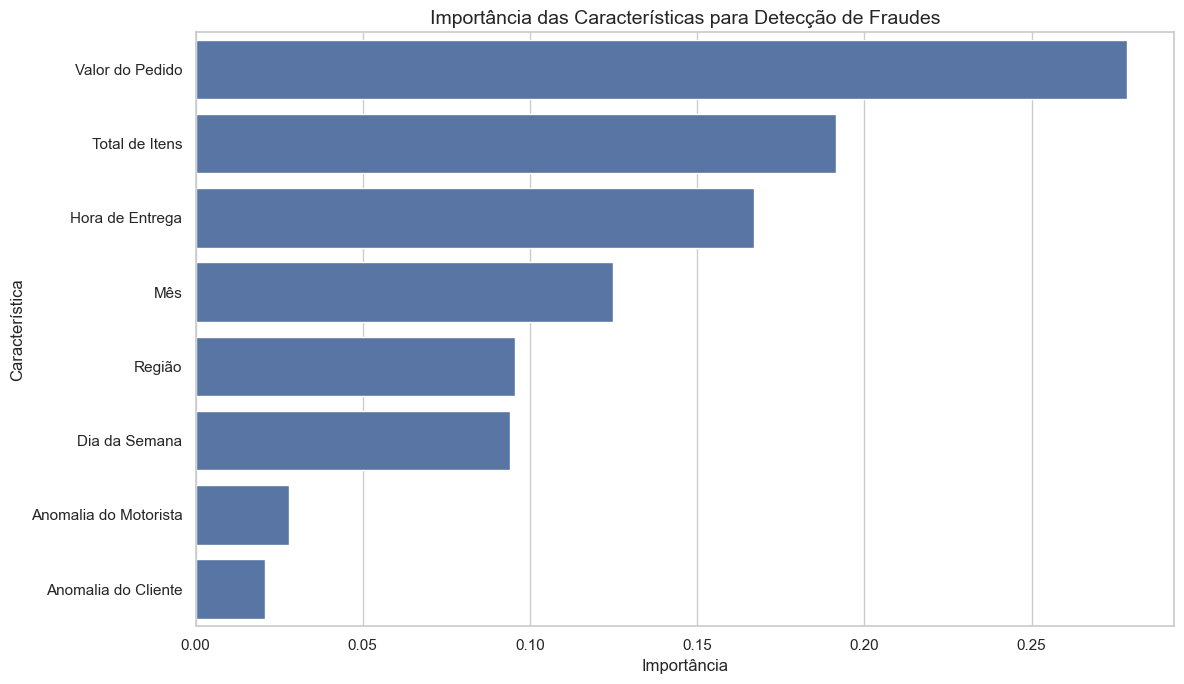

In [181]:
# Plotando a importância das features EM PORTUGUÊS
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importância': rf_classifier.feature_importances_
}).sort_values(by='Importância', ascending=False)

# Mapeamento para nomes em português
feature_names_map = {
    'order_amount': 'Valor do Pedido',
    'total_items': 'Total de Itens',
    'delivery_hour_only': 'Hora de Entrega',
    'day_of_week': 'Dia da Semana',
    'month': 'Mês',
    'region_encoded': 'Região',
    'driver_anomaly': 'Anomalia do Motorista',
    'customer_anomaly': 'Anomalia do Cliente'
}

# Aplicando o mapeamento
feature_importance['Feature'] = feature_importance['Feature'].map(feature_names_map)

# Exibindo as 10 variáveis mais importantes
plt.figure(figsize=(12, 7))
sns.barplot(x='Importância', y='Feature', data=feature_importance.head(10))
plt.title('Importância das Características para Detecção de Fraudes', fontsize=14)
plt.xlabel('Importância', fontsize=12)
plt.ylabel('Característica', fontsize=12)
plt.tight_layout()
plt.show()

In [182]:
def create_predictive_model(order_features, driver_features, customer_features, region_features):
    """
    Cria um modelo preditivo para identificar pedidos com alto risco de fraude.
    """
    # Juntando as features de motoristas e clientes com os pedidos
    order_features = order_features.merge(driver_features[['driver_id', 'anomaly']], on='driver_id', how='left')
    order_features = order_features.merge(customer_features[['customer_id', 'anomaly']], on='customer_id', how='left')

    # Verificando as colunas após o merge
    print("Colunas após o merge:", order_features.columns)

    # Renomeando as colunas de anomalia para evitar conflitos
    order_features = order_features.rename(columns={
        'anomaly_x': 'driver_anomaly',  # Renomeia a coluna de anomalia dos motoristas
        'anomaly_y': 'customer_anomaly'  # Renomeia a coluna de anomalia dos clientes
    })

    # Verificando as colunas após a renomeação
    print("Colunas após renomeação:", order_features.columns)

    # Verificando se a coluna 'region' existe antes de codificá-la
    if 'region' in order_features.columns:
        label_encoder = LabelEncoder()
        order_features['region_encoded'] = label_encoder.fit_transform(order_features['region'])
    else:
        print("A coluna 'region' não foi encontrada no DataFrame!")

    # Verificando as colunas após a criação de 'region_encoded'
    print("Colunas após a criação de 'region_encoded':", order_features.columns)

    # Adicionando features da região
    order_features = order_features.merge(region_features[['region', 'problem_order_ratio']], on='region', how='left')

    # Criando a variável alvo
    threshold = 0.2
    order_features['high_risk'] = (order_features['missing_ratio'] > threshold).astype(int)

    # Verificando as colunas após a criação da variável 'high_risk'
    print("Colunas após a criação de 'high_risk':", order_features.columns)

    # Verifique se as colunas necessárias estão presentes no DataFrame
    required_columns = ['order_amount', 'total_items', 'delivery_hour_only', 'day_of_week', 'month', 
                       'region_encoded', 'driver_anomaly', 'customer_anomaly']

    missing_columns = [col for col in required_columns if col not in order_features.columns]
    if missing_columns:
        print(f"Faltando as seguintes colunas: {missing_columns}")
    else:
        print("Todas as colunas necessárias estão presentes.")

    # Preparando as features para o modelo
    try:
        X = order_features[required_columns]
        y = order_features['high_risk']
    except KeyError as e:
        print(f"Erro ao acessar as colunas: {e}")
        print("Colunas disponíveis:", order_features.columns)

    # Dividindo os dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Treinando o modelo de Random Forest
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)

    # Retorna tanto o modelo quanto o DataFrame modificado
    return rf_classifier, order_features

Iniciando o processo de análise e modelagem...
A coluna 'missing_ratio' existe em driver_features!
A coluna 'missing_ratio' existe em customer_features!
Dados carregados com sucesso!
Anomalias detectadas com sucesso!
Colunas após o merge: Index(['order_id', 'driver_id', 'customer_id', 'region', 'order_amount',
       'items_delivered', 'items_missing', 'total_items', 'missing_ratio',
       'delivery_hour_only', 'day_of_week', 'month', 'anomaly_x', 'anomaly_y'],
      dtype='object')
Colunas após renomeação: Index(['order_id', 'driver_id', 'customer_id', 'region', 'order_amount',
       'items_delivered', 'items_missing', 'total_items', 'missing_ratio',
       'delivery_hour_only', 'day_of_week', 'month', 'driver_anomaly',
       'customer_anomaly'],
      dtype='object')
Colunas após a criação de 'region_encoded': Index(['order_id', 'driver_id', 'customer_id', 'region', 'order_amount',
       'items_delivered', 'items_missing', 'total_items', 'missing_ratio',
       'delivery_hour_onl

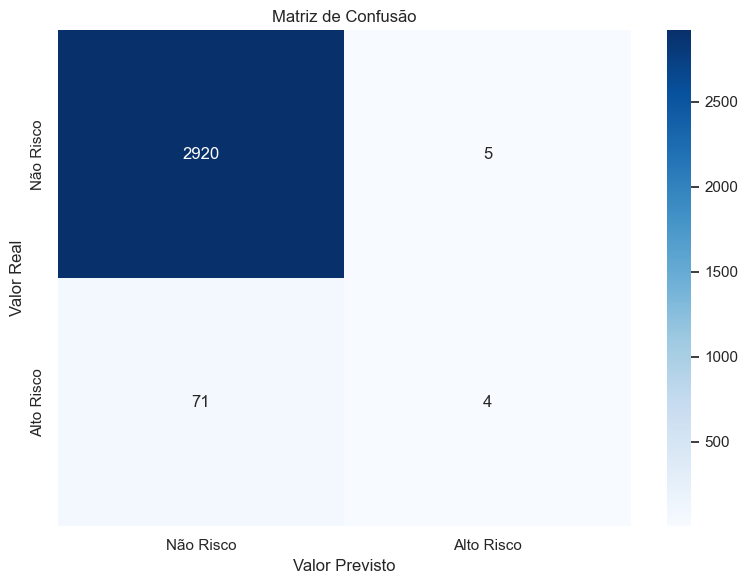

Relatório de Classificação:
              precision    recall  f1-score   support

   Não Risco       0.98      1.00      0.99      2925
  Alto Risco       0.44      0.05      0.10        75

    accuracy                           0.97      3000
   macro avg       0.71      0.53      0.54      3000
weighted avg       0.96      0.97      0.96      3000



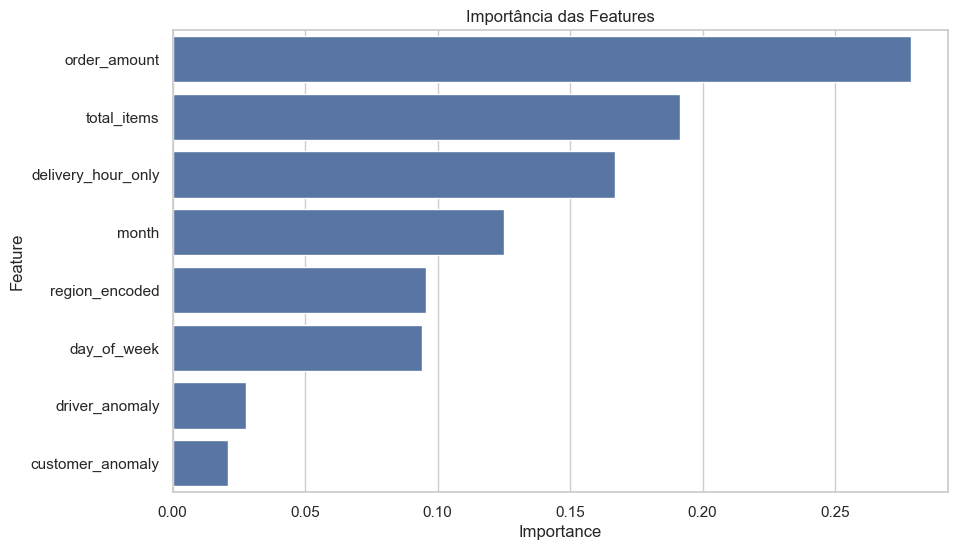

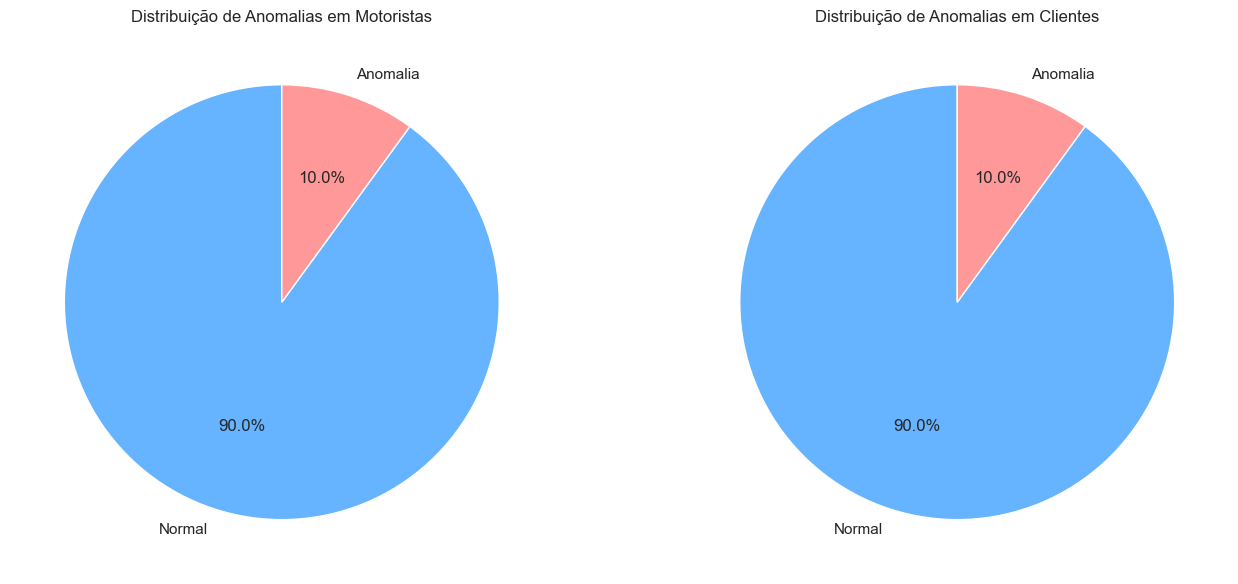

In [183]:
# Função principal
def main():
    print("Iniciando o processo de análise e modelagem...")

    # Carregar dados
    conn, orders_df, drivers_df, customers_df, missing_items_df, products_df, driver_features, customer_features, region_features, order_features = load_and_prepare_data()
    print("Dados carregados com sucesso!")

    # Detectar anomalias
    anomaly_drivers, customer_features = detect_anomalies_with_isolation_forest(driver_features, customer_features)
    print("Anomalias detectadas com sucesso!")

    # Criar o modelo preditivo e obter o DataFrame modificado
    rf_classifier, modified_order_features = create_predictive_model(order_features, driver_features, customer_features, region_features)
    print("Modelo preditivo criado com sucesso!")

    print("Processo concluído!")
    
    # Retorna o modelo, os dados modificados e as features dos motoristas e clientes
    return rf_classifier, modified_order_features, driver_features, customer_features

# Execução do script
if __name__ == "__main__":
    rf_classifier, modified_order_features, driver_features, customer_features = main()
    
    # Avaliar o modelo utilizando métricas como precisão, recall, F1-Score e matriz de confusão
    from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
    
    # Agora use modified_order_features que já contém todas as colunas necessárias
    X = modified_order_features[[
        'order_amount', 'total_items', 'delivery_hour_only', 'day_of_week', 'month', 
        'region_encoded', 'driver_anomaly', 'customer_anomaly'
    ]]
    y = modified_order_features['high_risk']

    # Dividindo os dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Fazendo previsões no conjunto de teste
    y_pred = rf_classifier.predict(X_test)

    # Calculando as métricas
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

        # Exibindo as métricas EM PORTUGUÊS
    print(f'Precisão: {precision:.4f}')
    print(f'Revocação: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')
    print('Matriz de Confusão:')
    print(conf_matrix)

    # Opcional: Você pode exibir a matriz de confusão como um heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Não Risco', 'Alto Risco'],
                yticklabels=['Não Risco', 'Alto Risco'])
    plt.title('Matriz de Confusão')
    plt.ylabel('Valor Real')
    plt.xlabel('Valor Previsto')
    plt.tight_layout()
    plt.show()

    # Exibindo o relatório de classificação em português
    print('Relatório de Classificação:')
    print(classification_report(y_test, y_pred, 
                            target_names=['Não Risco', 'Alto Risco']))
    # Plotando a importância das features
    import matplotlib.pyplot as plt
    import seaborn as sns

    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_classifier.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    # Exibindo as 10 variáveis mais importantes
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
    plt.title('Importância das Features')
    plt.show()

    # Plotando a distribuição de anomalias detectadas
    plt.figure(figsize=(14, 6))

    # Gráfico para motoristas
    plt.subplot(1, 2, 1)
    anomalias_motoristas = driver_features['anomaly'].value_counts()
    plt.pie(anomalias_motoristas, labels=[('Normal', 'Anomalia')[i == -1] for i in anomalias_motoristas.index], 
            autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
    plt.title('Distribuição de Anomalias em Motoristas')

    # Gráfico para clientes
    plt.subplot(1, 2, 2)
    anomalias_clientes = customer_features['anomaly'].value_counts()
    plt.pie(anomalias_clientes, labels=[('Normal', 'Anomalia')[i == -1] for i in anomalias_clientes.index], 
            autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
    plt.title('Distribuição de Anomalias em Clientes')

    plt.tight_layout()
    plt.show()
 